<a href="https://colab.research.google.com/github/johanhoffman/crocodile-heart/blob/master/DarcyFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# Setup environment

In [115]:
# Setup FEniCS environment 
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot
import matplotlib.pyplot as plt

import time 

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

dolfin version: 2019.1.0


# Define domain and mesh

In [0]:
# Define domain
L = 4
H = 1

# Define subdomains
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

resolution = 16

# Generate mesh 
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

# Define mesh functions 
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

# Define periodic domain 
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - L
        y[1] = x[1]

# Define approximation spaces

In [0]:
# Generate finite element spaces
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)
K = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Define boundary conditions

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] > (H - DOLFIN_EPS) and on_boundary)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] > (L - DOLFIN_EPS) and on_boundary)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

p0 = 2.0
p1 = 1.0
bcp0 = DirichletBC(Q, p0, dbc_left) 
bcp1 = DirichletBC(Q, p1, dbc_right)

bcp = [bcp0, bcp1]

# Define method parameters

In [0]:
# Define functions
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set model parameters
#k = Expression('x[1]', element = K.ufl_element())
#k = Expression('x[0]*x[1]*(1.0 - x[1])*(4.0-x[0])', element = K.ufl_element())
k = Expression('1.0e-2 + fabs(sin(2*pi*x[1]))', element = K.ufl_element())

# Set method parameters
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

# Define measure for boundary inntegration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational problem

In [0]:
# Define variational problems
Fp = (1/dt)*(p - p0)*q*dx + k*inner(grad(p), grad(q))*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

# Assemble linear matrix 
Ap = assemble(ap)

# Define variational problem
au = dot(u, v)*dx
Lu = inner(grad(p1),v)*dx

# Assemble linear matrix 
Au = assemble(au)

# Set I/O variables

In [0]:
# Open files
file_u = File("results/u.pvd")
file_p = File("results/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Time stepping algorithm

Time t = 0.04419417382415922


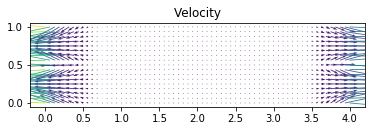

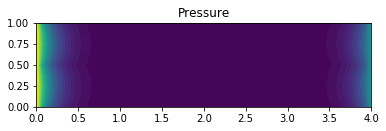

Time t = 10.032077458084187


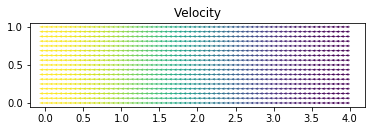

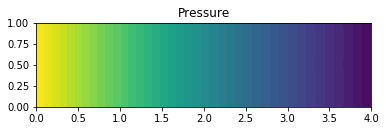

Time t = 20.01996074234425


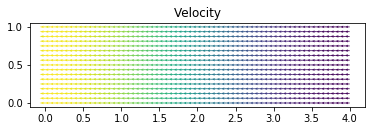

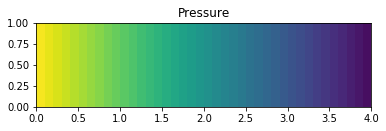

Time t = 30.007844026604314


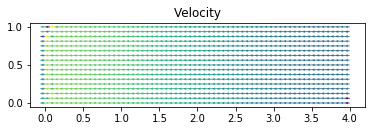

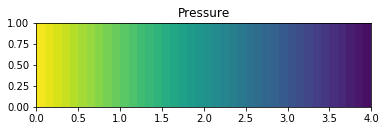

Time t = 40.039921484688534


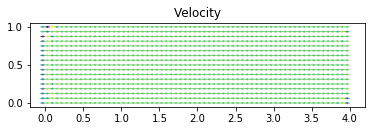

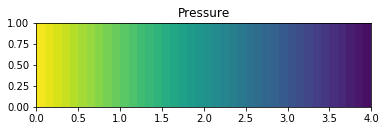

Time t = 50.0278047689486


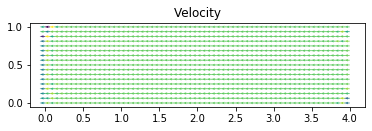

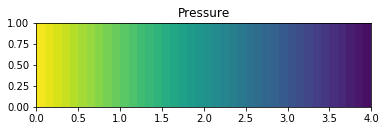

Time t = 60.01568805320866


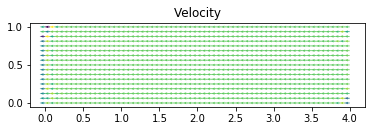

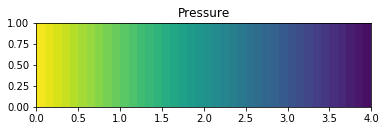

Time t = 70.00357133746776


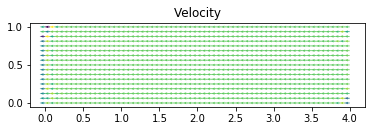

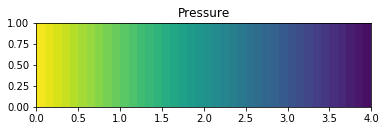

Time t = 80.03564879555037


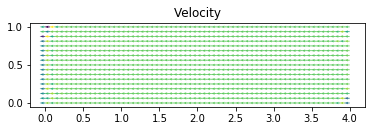

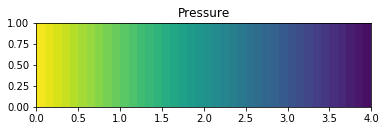

Time t = 90.02353207980883


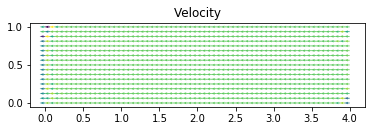

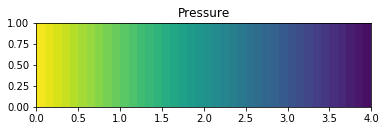

In [122]:
# Time stepping 
T = 100
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    # Time step problem 
        
    # Assemble vector 
    bp = assemble(Lp)

    # Compute solution 
    [bc.apply(Ap, bp) for bc in bcp]
    [bc.apply(p1.vector()) for bc in bcp]
    solve(Ap, p1.vector(), bp, "bicgstab", prec)

    # Assemble vector 
    bu = assemble(Lu)

    # Compute solution 
    solve(Au, u1.vector(), bu, "bicgstab", prec)

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

    # Update time step
    p0.assign(p1)
    t += dt

plt.show()